In [3]:
%%capture
!pip install apimoex
!pip install requests pandas
!pip install requests beautifulsoup4
!pip install mpl_finance

In [5]:
import pandas as pd
import numpy as np
import requests
import apimoex
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from bs4 import BeautifulSoup
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as sts
from mpl_finance import candlestick_ohlc 
import matplotlib.dates as mpl_dates 

In [6]:
df_ROSN = pd.read_csv('ROSN_trades_2021-01-01_to_2024-04-01.csv')  
df_SBER = pd.read_csv('SBER_trades_2021-01-01_to_2024-04-01.csv')  
df_LKOH = pd.read_csv('LKOH_trades_2021-01-01_to_2024-04-01.csv')  
df_SI = pd.read_csv('SI_trades_2021-01-01_to_2024-04-01.csv')  
df_BR = pd.read_csv('BR_trades_2021-01-01_to_2024-04-01.csv')  
df_IMOEX = pd.read_csv('IMOEX_trades_2021-01-01_to_2024-04-01.csv')  

## **Описание всех признаков (до отбора необходимых)**

* **"BOARDID"** - обозначает идентификатор торговой сессии.

Этот идентификатор используется для указания конкретной сессии торгов, например, основной сессии торгов, аукциона закрытия или аукциона открытия. Каждая сессия торгов может иметь свой уникальный идентификатор, который помогает участникам рынка и системам обработки понимать, в каком режиме в данный момент происходят торги.

* **SMAL** - Сегмент малой капитализации.
Включает в себя акции компаний с небольшой рыночной капитализацией, то есть сравнительно небольшим объёмом эмитированных акций и общей стоимостью рыночных цен их акций.
Торговые инструменты: В основном, это акции компаний с низкой капитализацией.

* **TQBR:** - Сегмент классического списка ценных бумаг.

Включает в себя акции и другие финансовые инструменты крупных российских и иностранных компаний, соответствующие высоким стандартам ликвидности, прозрачности и отчетности.
Торговые инструменты: Акции крупных компаний, облигации, фондовые индексы и другие.

* **SPEQ:** - Сегмент ценных бумаг, отобранных по критериям качества.

Включает в себя акции компаний, которые соответствуют определенным критериям качества, таким как финансовая устойчивость, прозрачность, эффективное управление и т. д.
Торговые инструменты: Акции компаний, которые были отобраны на основе определенных критериев качества.


* **"TRADEDATE"** обозначает дату, на которую относится торговая информация или сделки.

* **SHORTNAME** - имя компании (поскольку мы в дальнейшем будем добавлять акции котировки компаний отличных от Росснефть для поиска дальнейших взаимосвязей, пока не будем удалять данный признак, несмотря на то, что на данный момент он состоит лишь из одной акции)

* **"SECID"** - это идентификатор, который используется для однозначной идентификации конкретного финансового инструмента. Каждый инструмент, такой как акция, облигация или другие торгуемые активы, имеет свой уникальный SECID.

* **"VALUE"** обычно относится к общей стоимости сделок, совершенных в течение определенного периода времени или для конкретного финансового инструмента на бирже. Этот показатель представляет собой сумму денежных средств, которая была передана в результате совершенных сделок. (руб.)

* **"NUMTRADES"** представляет собой количество (объем) сделок, совершенных в течение определенного периода торговли или для конкретного финансового инструмента на бирже. (шт.)

* **OPEN:** - Цена открытия торгового периода.

Это цена первой сделки, совершенной в начале торгового дня или периода.

* **LOW:** - Наименьшая цена сделки за торговый период.

Это самая низкая цена, по которой была совершена сделка за данный торговый период.

* **HIGH:** - Наибольшая цена сделки за торговый период.

Это самая высокая цена, по которой была совершена сделка за данный торговый период.

* **LEGALCLOSEPRICE:** - Официальная цена закрытия торгового периода.

Это цена, по которой последняя сделка была совершена в конце торгового дня или периода.

* **WAPRICE:** - Средневзвешенная цена.

Это средневзвешенная цена всех сделок за определенный период времени.

* **CLOSE:** - Фактическая цена закрытия торгового периода.

Это цена последней сделки перед закрытием торгового дня или периода.

* **VOLUME:** - Объем сделок.

Это общее количество акций или других финансовых инструментов, которые были куплены или проданы за определенный период времени.

* **MARKETPRICE2**

это рыночная цена, используемая для оценки портфелей управляющими активами и пенсионными фондами в конце торгового дня.

* **MARKETPRICE3**

это еще одна рыночная цена, используемая на бирже для расчетов и отчетности. Она часто применяется для окончательного расчета стоимости активов на конец торгового дня, учитывая последние торговые операции.

* **ADMITTEDQUOTE:** - Допущенная котировка.

Это цена, которая допущена к использованию в расчетах индексов или других финансовых показателей.

* **MP2VALTRD и MARKETPRICE3TRADESVALUE:** - Сумма сделок по рыночной цене 2 и 3.

Это общая сумма денег, которая была потрачена или заработана на сделках по рыночной цене 2 и 3 соответственно.

* **ADMITTEDVALUE:** - Допущенная стоимость.

На Московской бирже (MOEX) относится к цене, которая была официально принята для использования в расчетах индексов или других финансовых показателей.

* **WAVAL:** - Взвешенная средняя стоимость.

Это средневзвешенная стоимость всех сделок за определенный период времени.

* **TRADINGSESSION:** - Торговая сессия.

Это информация о том, в какой торговой сессии была совершена сделка или приведены другие финансовые данные.

* **CURRENCYID:** - Идентификатор валюты.

Это код валюты, используемый для выражения цен и объемов валютных операций.

* **TRENDCLSPR:** - Тенденция цен закрытия.

Это показатель, который может указывать на направление изменения цен закрытия, например, рост, падение или стабильност

## **Отбор признаков котировок акций**

Ранее мы уже заметили проблему того, что одной дате соответствует несколько наблюдений, что приводит к разным размерностям массивов, отвечающих за котировки акций (Росснефть, Сбер, Лукойл). Данная проблема возникает из-за наличия разных торговых сессий в одну дату, из-за чего одной дате соответствует несколько наблюдений на разных торговых сессиях. Мы решили оставить сугубо одну торговую сессию : **TQBR:** - Сегмент классического списка ценных бумаг.

**Почему мы выбрали сессию TQBR:**

TQBR включает в себя акции крупнейших и наиболее ликвидных компаний, что делает эту сессию наиболее представительной для анализа общих трендов на рынке.Ограничение анализа одной торговой сессией устраняет проблему разных размерностей массивов данных за счёт исключения дублирующих и противоречивых записей, обеспечивая тем самым большую чистоту и согласованность аналитической базы. Поскольку TQBR охватывает акции крупнейших компаний, результаты торгов в этой сессии часто используются аналитиками и инвесторами как барометр общего состояния экономики. Акции этих компаний могут демонстрировать реакцию на экономические, политические и социальные изменения, предоставляя важные данные для макроэкономического анализа.

**Обоснование исключения "SMALL":**

Если цель анализа — изучение крупных и ликвидных компаний, данные по малым компаниям (как предполагает "SMALL") могут быть не так важны, поскольку они могут вести себя по-разному по сравнению с крупными компаниями и вносить шум в общий анализ.

Торги по малокапитализированным акциям часто характеризуются низкой ликвидностью и высокой волатильностью, что может привести к статистическим искажениям в моделях, основанных на более стабильных данных крупных компаний в сегменте "TQBR".

Исключение менее релевантных данных помогает сократить сложность модели, улучшить ее интерпретируемость и возможно повысить точность предсказаний на данных крупных и более предсказуемых компаний.

Концентрация на "TQBR" позволяет анализировать торговые сессии, где представлены ключевые игроки рынка, что более важно для разработки стратегий вложений и торговли акциями крупных компаний.

Малокапитализированные компании могут быть подвержены спекулятивным операциям и манипуляциям на рынке, что делает данные по ним менее надежными для анализа в сравнении с данными по крупным компаниям.

Исключив "SMALL", мы уменьшаем риск включения в анализ данных, которые могут быть не так значимы для общих рыночных трендов, и сосредотачиваем внимание на более стабильных и репрезентативных метриках, что способствует более качественной и обоснованной аналитике. Это особенно важно при анализе для крупных инвестиционных проектов или портфельных инвестиций в значимые активы на фондовом рынке.

In [10]:
df_ROSN = df_ROSN[df_ROSN['BOARDID'] == 'TQBR']
df_SBER = df_SBER[df_SBER['BOARDID'] == 'TQBR']
df_LKOH = df_LKOH[df_LKOH['BOARDID'] == 'TQBR']

SHORTNAME	SECID являются дублирующими признаками, так как короткое имя однозначно восстанавливается из SECID и дублирует его. Поэтому короткое имя было удалено из датафрейма в качестве самостоятельного признака

MARKETPRICE2 и MARKETPRICE3 ориентированы на очень конкретные нужды биржевого учета и регуляторной отчетности, что может быть не релевантно для общего рыночного анализа или технического анализа. Если цель анализа — изучение общих трендов, динамики цен или разработка торговых стратегий, эти показатели могут не приносить дополнительной ценности.

Если доступны более стандартные метрики, такие как открытие, закрытие, минимум и максимум дня, MARKETPRICE2 и MARKETPRICE3 могут дублировать информацию, не добавляя значимого углубления в анализ.

Таким образом, для наших целей общего анализа котировок и рынка на котором торгуются акции нефтяной компании Росснефть и их прогнозирования данные специфичные цены, а также связанные с ними признаки будут излишними и могут быть удалены без потери общности.

 Взвешенная средняя стоимость почему-то не была спарсена, и выдавала константное значение 0 для всех дней. Поэтому она также была исключена из анализа

Поскольку все акции имеют вечернюю сессию и одинаковую CURRENCYID, то столбцы этих признаков содержат константное значение 3 и SUR. Поэтому они неинформативны, а следовательно исключены из нашего дальнейшего анализа. Мы просто запомним, что сессия - вечерняя, что будет использовано дальше в следующем разделе

In [11]:
print(df_ROSN['WAVAL'].unique())
print(df_SBER['WAVAL'].unique())
print(df_LKOH['WAVAL'].unique())

[0]
[0]
[0]


In [12]:
df_ROSN.drop(['SHORTNAME', 'LEGALCLOSEPRICE', 'MARKETPRICE2', 'MARKETPRICE3', 'MP2VALTRD', 'MARKETPRICE3TRADESVALUE','WAVAL', 'TRADINGSESSION', 'CURRENCYID'], axis=1, inplace=True)
df_SBER.drop(['SHORTNAME', 'LEGALCLOSEPRICE', 'MARKETPRICE2', 'MARKETPRICE3', 'MP2VALTRD', 'MARKETPRICE3TRADESVALUE', 'WAVAL', 'TRADINGSESSION', 'CURRENCYID'], axis=1, inplace=True)
df_LKOH.drop(['SHORTNAME', 'LEGALCLOSEPRICE', 'MARKETPRICE2', 'MARKETPRICE3', 'MP2VALTRD', 'MARKETPRICE3TRADESVALUE', 'WAVAL', 'TRADINGSESSION', 'CURRENCYID'], axis=1, inplace=True)

In [13]:
print(df_ROSN.shape)
print(df_SBER.shape)
print(df_LKOH.shape)

(823, 14)
(823, 14)
(823, 14)


Необходимо было сконкатинировать все наблюдения в один датафрейм, поэтому необходимо было разделить признаки акций компаний своим уникальным названием

In [14]:
df_STOCK_AGGREGATE = pd.concat([df_ROSN, df_SBER, df_LKOH], ignore_index=True)

Посмотрим на то, сколько пропусков в долевом отношении содержат признаки, отсутствующие признаки не содержат пропусков

In [15]:
print(f"Доля пропусков OPEN {df_STOCK_AGGREGATE['OPEN'].value_counts(dropna=False, normalize = True).iloc[0]}")
print(f"Доля пропусков LOW {df_STOCK_AGGREGATE['LOW'].value_counts(dropna=False, normalize = True).iloc[0]}")
print(f"Доля пропусков HIGH {df_STOCK_AGGREGATE['HIGH'].value_counts(dropna=False, normalize = True).iloc[0]}")
print(f"Доля пропусков WAPRICE {df_STOCK_AGGREGATE['WAPRICE'].value_counts(dropna=False, normalize = True).iloc[0]}")
print(f"Доля пропусков CLOSE {df_STOCK_AGGREGATE['CLOSE'].value_counts(dropna=False, normalize = True).iloc[0]}")
print(f"Доля пропусков ADMITTEDQUOTE {df_STOCK_AGGREGATE['ADMITTEDQUOTE'].value_counts(dropna=False, normalize = True).iloc[0]}")
print(f"Доля пропусков ADMITTEDVALUE {df_STOCK_AGGREGATE['ADMITTEDVALUE'].value_counts(dropna=False, normalize = True).iloc[0]}")
print(f"Доля пропусков TRENDCLSPR {df_STOCK_AGGREGATE['TRENDCLSPR'].value_counts(dropna=False, normalize = True).iloc[0]}")

Доля пропусков OPEN 0.02187120291616039
Доля пропусков LOW 0.02187120291616039
Доля пропусков HIGH 0.02187120291616039
Доля пропусков WAPRICE 0.02187120291616039
Доля пропусков CLOSE 0.02187120291616039
Доля пропусков ADMITTEDQUOTE 0.3730255164034022
Доля пропусков ADMITTEDVALUE 0.3730255164034022
Доля пропусков TRENDCLSPR 0.02187120291616039


Так как датафрейм содержит данные за разные периоды, заполнять пропуски средним значением за 3 года - крайне нелогичная идея, также как и заполнять медианой. В силу того, что данный метод не будет иметь никакой экономической интуиции в силу того, что за столь большой период времени структура рынка сильно изменилась. Удалять строки с пропусками - идея также сомнительная.Так как мы потеряем больше третьи информации. Лучше удалить данные два признака, чем терять столь много информации, а заполнить их чем-то логически неправильная идея.

In [16]:
df_STOCK_AGGREGATE.drop(['ADMITTEDQUOTE', 'ADMITTEDVALUE'], axis=1, inplace=True)

In [17]:
df_STOCK_AGGREGATE.dropna(inplace=True)

In [18]:
df_STOCK_AGGREGATE.isnull().any().any()

False

In [19]:
df_STOCK_AGGREGATE

,BOARDID,TRADEDATE,SECID,NUMTRADES,VALUE,OPEN,LOW,HIGH,WAPRICE,CLOSE,VOLUME,TRENDCLSPR
0,TQBR,2021-01-04,ROSN,22434,2.803388e+09,435.85,433.0,442.60,437.65,436.00,6405540,0.21
1,TQBR,2021-01-05,ROSN,23452,2.974642e+09,436.00,433.3,450.70,442.10,449.35,6728320,3.06
2,TQBR,2021-01-06,ROSN,27750,3.697371e+09,449.35,443.7,454.65,449.25,453.70,8230020,0.97
3,TQBR,2021-01-08,ROSN,42210,6.045034e+09,465.10,463.8,481.00,473.20,478.20,12774820,5.40
4,TQBR,2021-01-11,ROSN,29306,4.160569e+09,474.55,464.0,480.10,473.05,473.25,8794770,-1.04
...,...,...,...,...,...,...,...,...,...,...,...,...
2464,TQBR,2024-03-26,LKOH,32678,4.167015e+09,7454.50,7380.0,7455.00,7413.50,7419.00,562109,-0.26
2465,TQBR,2024-03-27,LKOH,31389,3.871128e+09,7425.50,7404.5,7497.00,7449.50,7493.00,519706,1.00
2466,TQBR,2024-03-28,LKOH,45393,3.728290e+09,7495.00,7430.5,7517.00,7473.50,7481.00,498911,-0.16
2467,TQBR,2024-03-29,LKOH,38352,5.309786e+09,7481.50,7460.0,7578.00,7529.50,7551.00,705061,0.94


Остальные пропуски в силу того, что их меньше 2% от общего числа наблюдений мы просто удалим из датасета в следующем разделе. Так как заполнять чем-то средним, медианой будет неправильно в силу экономического смысла. Нелогично брать среднее за столь большой период времени в рамках которого структура рынка сильно менялась ввиду некоторых политический событий.

## **Описание признаков фьючерсов на нефть и курс доллар-рубль**

### **Фьючерс на нефть**

Фьючерс на нефть — это финансовый контракт, который обязывает покупателя купить, а продавца продать определенное количество нефти в установленное время в будущем по заранее оговоренной цене. Фьючерсные контракты стандартизированы по объему, качеству, условиям поставки и другим параметрам, что позволяет им свободно торговаться на специализированных биржах. Торговля фьючерсами на нефть позволяет компаниям хеджировать риски, связанные с колебаниями цен на нефть, а также предоставляет трейдерам возможности для спекуляций.

Аббревиатура BR-x.y обычно используется для обозначения российских фьючерсных контрактов на нефть марки Urals, торгуемых на Московской бирже (MOEX). Здесь:

BR обозначает "Brent Russia", что указывает на тип нефти. Иногда это может трактоваться как аналог брентовской нефти или просто как ссылка на российскую нефть.
x — это номер месяца экспирации контракта, где 1 соответствует январю, 2 — февралю, и так далее до 12, который соответствует декабрю.
y — это последние две цифры года экспирации контракта.
Например, BR-3.21 обозначает фьючерсный контракт на нефть, экспирация которого происходит в марте 2021 года.

Однако зачастую могут использоваться другие обозначения.
Более подробно мы прочитали здесь https://www.moex.com/s205

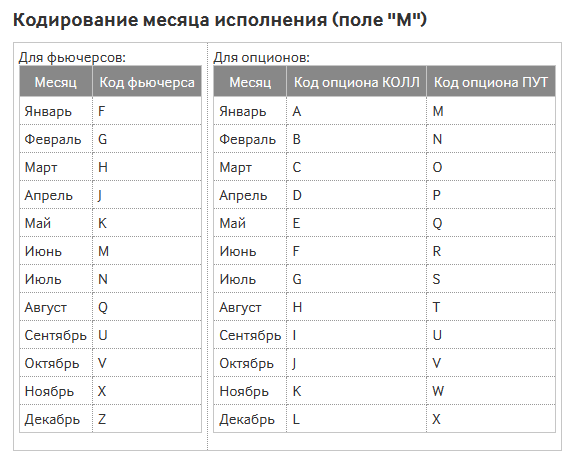

* **Date**: Дата торгового дня.
* **FuturesCode**: Код фьючерса или контракта на нефть Brent.
* **WeightedAvgPrice**: Взвешенная средняя цена сделок за торговый день.
* **SettlementPrice**: Цена, по которой закрылись торги в конце торгового дня.
* **FirstDealPrice**: Цена первой сделки в торговом дне.
* **MaxPrice**: Максимальная цена, достигнутая за торговый день.
* **MinPrice**: Минимальная цена, достигнутая за торговый день.
* **LastDealPrice**: Цена последней сделки в торговом дне.
* **Change**: Изменение цены по сравнению с предыдущим торговым днем (обычно в процентах или абсолютном значении).
* **VolumeLastDeal**: Объем последней сделки.
* **NumOfDeals**: Количество сделок за торговый день.
* **TradingVolume RUB**: Объем торгов в российских рублях.
* **TradingVolume contr**: Объем торгов в контрактах (обычно фьючерсных).
* **OpenPositionsVolume RUB**: Объем открытых позиций в российских рублях.
* **OpenPositionsVolume contr**: Объем открытых позиций в контрактах.
* **MarginRequirements**: Требования к маржинальному обеспечению для этого контракта.


Для того, чтобы можно было конкатинировать информацию об акциях и фьючерсов мы решили убрать из датафрема фьючерсов признаки, которые нам не потребуются в анализу. Это цена последней сделки LastDealPrice, так как этот признак дублирует CLOSE. Объем последний сделки VolumeLastDeal. Так как это признак, информацию о котором можно получить из объема сделки в рублях (зная стоимость фьючерса). Также данный признак не соотносится с признаками в датафрейме с акциями.

In [20]:
df_BR.drop(['LastDealPrice', 'VolumeLastDeal'], axis=1, inplace=True)

In [21]:
new_columns = {
    'Date': 'TRADEDATE',
    'FuturesCode': 'BOARDID',
    'WeightedAvgPrice': 'WAPRICE',
    'SettlementPrice': 'CLOSE',
    'FirstDealPrice': 'OPEN',
    'MaxPrice': 'HIGH',
    'MinPrice': 'LOW',
    'Change': 'TRENDCLSPR',
    'NumOfDeals': 'NUMTRADES',
    'TradingVolume RUB': 'TradingVolume_RUB',
    'TradingVolume contr': 'TradingVolume_CONTR',
    'OpenPositionsVolume RUB': 'OpenPositionsVolum_RUB',
    'OpenPositionsVolume contr': 'OpenPositionsVolum_CONTR',
    'MarginRequirements': 'MarginRequirements'
}

df_BR = df_BR.rename(columns=new_columns)

Теперь посмотрим на пропуски

Первые несколько строчек и последние были полностью пустыми в силу специфики предоставленных данных для парсина на сайте мосбиржи. Поэтому их нужно было удалить

In [22]:
df_BR = df_BR[2:825]

In [23]:
df_BR.replace('-', np.nan, inplace=True)

In [24]:
missing_values = df_BR.isnull().sum()
print(missing_values)

TRADEDATE                    0
BOARDID                      0
WAPRICE                      1
CLOSE                        0
OPEN                         1
HIGH                         1
LOW                          1
TRENDCLSPR                   5
NUMTRADES                    1
TradingVolume_RUB            1
TradingVolume_CONTR          1
OpenPositionsVolum_RUB      40
OpenPositionsVolum_CONTR    40
MarginRequirements           0
dtype: int64


In [25]:
df_BR.dropna(inplace = True)

Больше пропусков нет

In [26]:
df_BR

,TRADEDATE,BOARDID,WAPRICE,CLOSE,OPEN,HIGH,LOW,TRENDCLSPR,NUMTRADES,TradingVolume_RUB,TradingVolume_CONTR,OpenPositionsVolum_RUB,OpenPositionsVolum_CONTR,MarginRequirements
3,05.01.2021,BRG1,"51,73","52,87","51,24","53,06","50,58","+2,58 %",154 728,74 458 569 937,1 937 554,14 354 505 023,365 456,10 978
4,06.01.2021,BRG1,"53,76","54,33","52,94","54,62","52,67","+2,88 %",193 366,98 866 320 215,2 486 797,17 508 172 524,435 758,11 107
5,08.01.2021,BRG1,"54,69","55,42","54,31","55,49","53,11","+2,00 %",142 468,71 925 211 898,1 768 768,18 937 569 926,459 570,9 046
6,11.01.2021,BRG1,"55,41","55,56","55,43","56,16","55,01","+0,18 %",125 354,56 102 626 259,1 354 714,19 055 391 580,458 902,9 078
7,12.01.2021,BRG1,"56,23","56,49","55,6","56,77","55,38","+1,58 %",139 047,89 514 883 910,2 159 580,40 764 531 536,978 984,9 156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,25.03.2024,BRJ4,"86,17","86,8","85,76","87,18","85,36","+1,16 %",48 342,16 274 105 943,203 783,13 332 204 921,165 736,16 829
820,26.03.2024,BRJ4,"86,64","86,64","86,75","87,07","86,15","-0,18 %",45 322,13 856 998 065,172 471,12 941 882 002,161 082,16 751
821,27.03.2024,BRJ4,"85,8","86,07","86,59","86,73","85,26","-0,70 %",47 362,14 233 157 744,180 098,11 289 183 773,142 392,16 608
822,28.03.2024,BRJ4,"86,67","87,3","86,02","87,47","85,61","+1,44 %",43 196,13 822 924 687,172 455,8 538 681 599,105 754,16 766


### **Фьючерс на доллар-рубль.**

Спарсенные данные фьючерса на доллар-рубль имеет аналогичные признаки и структуру как и датафрейм фьючерсов на Нефть, поэтому повторно описывать признаки не имело смысла. Описание аналогично предыдущим. Проделаем с датафреймом валютных фьючерсов тоже самое, что и с фьючерсами на нефть

Использование фьючерса на рубль-доллар вместо обычного курса валюты во время вечерней сессии акций может быть обосновано несколькими причинами:

Ликвидность и доступность: Фьючерсы на рубль-доллар обычно более ликвидны и доступны для торговли даже во внебиржевом (after-hours) периоде. В то время как рынок Forex, где торгуется обычный курс валюты, может быть закрыт или иметь ограниченную ликвидность в некоторые часы.
Быстрота исполнения ордеров: Фьючерсы обычно торгуются на централизованных биржах, что может обеспечить более быстрое исполнение ордеров и меньшие задержки в сравнении с рынком Forex

**Курс валюты может изменяться в течение всех торговых сессий, включая утреннюю, дневную и вечернюю сессии. С другой стороны, фьючерсы на валюту, такие как фьючерсы на рубль-доллар, как правило, торгуются только во внебиржевой (after-hours) сессии, также как и акции. В результате, трейдеры и инвесторы могут использовать фьючерсы в вечерней сессии для защиты от рисков и спекуляции на изменения курсов валют. То есть акцент на выбор фьчерса на валюты был сделан с той целью, чтобы валюта и фьчерс на нефть торговались в одни и те же сессии.**

In [27]:
df_SI.drop(['LastDealPrice', 'VolumeLastDeal'], axis=1, inplace=True)

In [28]:
new_columns = {
    'Date': 'TRADEDATE',
    'FuturesCode': 'BOARDID',
    'WeightedAvgPrice': 'WAPRICE',
    'SettlementPrice': 'CLOSE',
    'FirstDealPrice': 'OPEN',
    'MaxPrice': 'HIGH',
    'MinPrice': 'LOW',
    'Change': 'TRENDCLSPR',
    'NumOfDeals': 'NUMTRADES',
    'TradingVolume RUB': 'TradingVolume_RUB',
    'TradingVolume contr': 'TradingVolume_CONTR',
    'OpenPositionsVolume RUB': 'OpenPositionsVolum_RUB',
    'OpenPositionsVolume contr': 'OpenPositionsVolum_CONTR',
    'MarginRequirements': 'MarginRequirements'
}

df_SI = df_SI.rename(columns=new_columns)

In [29]:
df_SI = df_SI[2:825]

In [30]:
df_SI.replace('-', np.nan, inplace=True)

In [31]:
df_SI.isnull().any().any()

True

In [32]:
missing_values = df_SI.isnull().sum()
print(missing_values)

TRADEDATE                    0
BOARDID                      0
WAPRICE                      1
CLOSE                        0
OPEN                         1
HIGH                         1
LOW                          1
TRENDCLSPR                   6
NUMTRADES                    1
TradingVolume_RUB            1
TradingVolume_CONTR          1
OpenPositionsVolum_RUB      13
OpenPositionsVolum_CONTR    13
MarginRequirements           0
dtype: int64


In [33]:
df_SI.dropna(inplace = True)

In [34]:
df_SI

,TRADEDATE,BOARDID,WAPRICE,CLOSE,OPEN,HIGH,LOW,TRENDCLSPR,NUMTRADES,TradingVolume_RUB,TradingVolume_CONTR,OpenPositionsVolum_RUB,OpenPositionsVolum_CONTR,MarginRequirements
2,04.01.2021,SiH1,74 151,74 468,75 175,75 175,73 555,"-0,97 %",628 063,234 450 156 953,3 161 789,195 876 605 928,2 630 346,6 165
3,05.01.2021,SiH1,75 122,74 747,74 500,75 818,74 403,"+0,43 %",911 840,304 227 626 196,4 049 800,183 061 382 760,2 449 080,6 187
4,06.01.2021,SiH1,74 323,74 506,74 780,74 780,73 908,"-0,39 %",768 465,235 490 576 934,3 168 486,184 370 163 408,2 474 568,6 165
5,08.01.2021,SiH1,74 709,74 800,74 455,75 350,74 165,"+0,36 %",866 939,274 503 458 591,3 674 288,185 417 531 200,2 478 844,5 061
6,11.01.2021,SiH1,75 069,75 298,74 764,75 528,74 510,"+0,68 %",819 343,285 988 439 605,3 809 695,208 163 278 748,2 764 526,5 093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,26.03.2024,SiM4,95 010,95 222,95 110,95 354,94 700,"+0,08 %",136 058,61 052 929 703,642 555,547 935 383 268,5 754 294,14 739
821,27.03.2024,SiM4,94 800,94 479,95 207,95 308,94 218,"-0,80 %",217 518,87 721 804 652,925 341,564 638 437 902,5 976 338,14 642
822,28.03.2024,SiM4,94 631,94 785,94 461,94 866,94 308,"+0,38 %",171 315,69 968 930 271,739 369,555 841 230 120,5 864 232,14 704
823,29.03.2024,SiM4,94 355,94 463,94 822,94 899,94 050,"-0,38 %",224 650,103 732 359 915,1 099 329,548 219 421 168,5 803 536,14 687


# **Предварительныя обработка данных (Обработка признаков)**

Для начала обработаем дату, переведя ее в более приемлемый вид

In [35]:
expected_format = '%d.%m.%Y'
alternative_format = '%Y-%m-%d'

try:
    df_STOCK_AGGREGATE['TRADEDATE'] = pd.to_datetime(df_STOCK_AGGREGATE['TRADEDATE'], format=expected_format)
except ValueError:
    df_STOCK_AGGREGATE['TRADEDATE'] = pd.to_datetime(df_STOCK_AGGREGATE['TRADEDATE'], format=alternative_format)

try:
    df_BR['TRADEDATE'] = pd.to_datetime(df_BR['TRADEDATE'], format=expected_format)
except ValueError:
    df_BR['TRADEDATE'] = pd.to_datetime(df_BR['TRADEDATE'], format=alternative_format)

try:
    df_SI['TRADEDATE'] = pd.to_datetime(df_SI['TRADEDATE'], format=expected_format)
except ValueError:
    df_SI['TRADEDATE'] = pd.to_datetime(df_SI['TRADEDATE'], format=alternative_format)

try:
    df_IMOEX['TRADEDATE'] = pd.to_datetime(df_IMOEX['TRADEDATE'], format=expected_format)
except ValueError:
    df_IMOEX['TRADEDATE'] = pd.to_datetime(df_IMOEX['TRADEDATE'], format=alternative_format)


In [36]:
df_STOCK_AGGREGATE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2415 entries, 0 to 2468
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   BOARDID     2415 non-null   object        
 1   TRADEDATE   2415 non-null   datetime64[ns]
 2   SECID       2415 non-null   object        
 3   NUMTRADES   2415 non-null   int64         
 4   VALUE       2415 non-null   float64       
 5   OPEN        2415 non-null   float64       
 6   LOW         2415 non-null   float64       
 7   HIGH        2415 non-null   float64       
 8   WAPRICE     2415 non-null   float64       
 9   CLOSE       2415 non-null   float64       
 10  VOLUME      2415 non-null   int64         
 11  TRENDCLSPR  2415 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 245.3+ KB


In [37]:
df_BR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779 entries, 3 to 823
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TRADEDATE                 779 non-null    datetime64[ns]
 1   BOARDID                   779 non-null    object        
 2   WAPRICE                   779 non-null    object        
 3   CLOSE                     779 non-null    object        
 4   OPEN                      779 non-null    object        
 5   HIGH                      779 non-null    object        
 6   LOW                       779 non-null    object        
 7   TRENDCLSPR                779 non-null    object        
 8   NUMTRADES                 779 non-null    object        
 9   TradingVolume_RUB         779 non-null    object        
 10  TradingVolume_CONTR       779 non-null    object        
 11  OpenPositionsVolum_RUB    779 non-null    object        
 12  OpenPositionsVolum_CON

Мы должны поменять тип данных в датафреймах отвечающих за фьючерсы. Так как сейчас они являются object, а не float или int

In [38]:
def correct_values(value):
    value_str = str(value).replace('\xa0', ' ')
    value_str = value_str.replace(' ', '')
    value_str = value_str.replace(',', '.')
    if '%' in value_str:
      if "+" in value_str:
        value_str = float(value_str[1:-1])/100
      else:
        value_str = float(value_str[:-1])/100
    return float(value_str)

In [39]:
for i in df_BR.columns:
    if i not in ['TRADEDATE', 'BOARDID']:
        df_BR.loc[:, i] = df_BR[i].apply(correct_values)

In [40]:
df_BR

,TRADEDATE,BOARDID,WAPRICE,CLOSE,OPEN,HIGH,LOW,TRENDCLSPR,NUMTRADES,TradingVolume_RUB,TradingVolume_CONTR,OpenPositionsVolum_RUB,OpenPositionsVolum_CONTR,MarginRequirements
3,2021-01-05,BRG1,51.73,52.87,51.24,53.06,50.58,0.0258,154728.0,7.445857e+10,1937554.0,1.435451e+10,365456.0,10978.0
4,2021-01-06,BRG1,53.76,54.33,52.94,54.62,52.67,0.0288,193366.0,9.886632e+10,2486797.0,1.750817e+10,435758.0,11107.0
5,2021-01-08,BRG1,54.69,55.42,54.31,55.49,53.11,0.0200,142468.0,7.192521e+10,1768768.0,1.893757e+10,459570.0,9046.0
6,2021-01-11,BRG1,55.41,55.56,55.43,56.16,55.01,0.0018,125354.0,5.610263e+10,1354714.0,1.905539e+10,458902.0,9078.0
7,2021-01-12,BRG1,56.23,56.49,55.60,56.77,55.38,0.0158,139047.0,8.951488e+10,2159580.0,4.076453e+10,978984.0,9156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2024-03-25,BRJ4,86.17,86.80,85.76,87.18,85.36,0.0116,48342.0,1.627411e+10,203783.0,1.333220e+10,165736.0,16829.0
820,2024-03-26,BRJ4,86.64,86.64,86.75,87.07,86.15,-0.0018,45322.0,1.385700e+10,172471.0,1.294188e+10,161082.0,16751.0
821,2024-03-27,BRJ4,85.80,86.07,86.59,86.73,85.26,-0.0070,47362.0,1.423316e+10,180098.0,1.128918e+10,142392.0,16608.0
822,2024-03-28,BRJ4,86.67,87.30,86.02,87.47,85.61,0.0144,43196.0,1.382292e+10,172455.0,8.538682e+09,105754.0,16766.0


In [41]:
for i in df_SI.columns:
    if i not in ['TRADEDATE', 'BOARDID']:
        df_SI.loc[:, i] = df_SI[i].apply(correct_values)

In [42]:
df_SI

,TRADEDATE,BOARDID,WAPRICE,CLOSE,OPEN,HIGH,LOW,TRENDCLSPR,NUMTRADES,TradingVolume_RUB,TradingVolume_CONTR,OpenPositionsVolum_RUB,OpenPositionsVolum_CONTR,MarginRequirements
2,2021-01-04,SiH1,74151.0,74468.0,75175.0,75175.0,73555.0,-0.0097,628063.0,2.344502e+11,3161789.0,1.958766e+11,2630346.0,6165.0
3,2021-01-05,SiH1,75122.0,74747.0,74500.0,75818.0,74403.0,0.0043,911840.0,3.042276e+11,4049800.0,1.830614e+11,2449080.0,6187.0
4,2021-01-06,SiH1,74323.0,74506.0,74780.0,74780.0,73908.0,-0.0039,768465.0,2.354906e+11,3168486.0,1.843702e+11,2474568.0,6165.0
5,2021-01-08,SiH1,74709.0,74800.0,74455.0,75350.0,74165.0,0.0036,866939.0,2.745035e+11,3674288.0,1.854175e+11,2478844.0,5061.0
6,2021-01-11,SiH1,75069.0,75298.0,74764.0,75528.0,74510.0,0.0068,819343.0,2.859884e+11,3809695.0,2.081633e+11,2764526.0,5093.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,2024-03-26,SiM4,95010.0,95222.0,95110.0,95354.0,94700.0,0.0008,136058.0,6.105293e+10,642555.0,5.479354e+11,5754294.0,14739.0
821,2024-03-27,SiM4,94800.0,94479.0,95207.0,95308.0,94218.0,-0.0080,217518.0,8.772180e+10,925341.0,5.646384e+11,5976338.0,14642.0
822,2024-03-28,SiM4,94631.0,94785.0,94461.0,94866.0,94308.0,0.0038,171315.0,6.996893e+10,739369.0,5.558412e+11,5864232.0,14704.0
823,2024-03-29,SiM4,94355.0,94463.0,94822.0,94899.0,94050.0,-0.0038,224650.0,1.037324e+11,1099329.0,5.482194e+11,5803536.0,14687.0


In [43]:
df_IMOEX.drop(['BOARDID', 'SECID','SHORTNAME','NAME','HIGH','LOW','VALUE', 'DURATION', 'YIELD', 'DECIMALS', 'CAPITALIZATION', 'CURRENCYID', 'DIVISOR', 'TRADINGSESSION', 'VOLUME'], axis=1, inplace=True)

In [44]:
df_IMOEX.set_index('TRADEDATE', inplace=True)

### **Финальные датасеты**

In [45]:
df_IMOEX

,CLOSE,OPEN
TRADEDATE,,
2021-01-04,3350.51,3306.12
2021-01-05,3359.15,3327.94
2021-01-06,3371.03,3373.37
2021-01-08,3454.82,3390.23
2021-01-11,3482.48,3455.67
...,...,...
2024-03-26,3285.54,3286.20
2024-03-27,3304.09,3291.70
2024-03-28,3312.77,3308.26


In [46]:
df_STOCK_AGGREGATE.set_index('TRADEDATE', inplace=True)

In [47]:
df_STOCK_AGGREGATE

,BOARDID,SECID,NUMTRADES,VALUE,OPEN,LOW,HIGH,WAPRICE,CLOSE,VOLUME,TRENDCLSPR
TRADEDATE,,,,,,,,,,,
2021-01-04,TQBR,ROSN,22434,2.803388e+09,435.85,433.0,442.60,437.65,436.00,6405540,0.21
2021-01-05,TQBR,ROSN,23452,2.974642e+09,436.00,433.3,450.70,442.10,449.35,6728320,3.06
2021-01-06,TQBR,ROSN,27750,3.697371e+09,449.35,443.7,454.65,449.25,453.70,8230020,0.97
2021-01-08,TQBR,ROSN,42210,6.045034e+09,465.10,463.8,481.00,473.20,478.20,12774820,5.40
2021-01-11,TQBR,ROSN,29306,4.160569e+09,474.55,464.0,480.10,473.05,473.25,8794770,-1.04
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26,TQBR,LKOH,32678,4.167015e+09,7454.50,7380.0,7455.00,7413.50,7419.00,562109,-0.26
2024-03-27,TQBR,LKOH,31389,3.871128e+09,7425.50,7404.5,7497.00,7449.50,7493.00,519706,1.00
2024-03-28,TQBR,LKOH,45393,3.728290e+09,7495.00,7430.5,7517.00,7473.50,7481.00,498911,-0.16


In [48]:
df_BR.set_index('TRADEDATE', inplace=True)

In [49]:
df_BR

,BOARDID,WAPRICE,CLOSE,OPEN,HIGH,LOW,TRENDCLSPR,NUMTRADES,TradingVolume_RUB,TradingVolume_CONTR,OpenPositionsVolum_RUB,OpenPositionsVolum_CONTR,MarginRequirements
TRADEDATE,,,,,,,,,,,,,
2021-01-05,BRG1,51.73,52.87,51.24,53.06,50.58,0.0258,154728.0,7.445857e+10,1937554.0,1.435451e+10,365456.0,10978.0
2021-01-06,BRG1,53.76,54.33,52.94,54.62,52.67,0.0288,193366.0,9.886632e+10,2486797.0,1.750817e+10,435758.0,11107.0
2021-01-08,BRG1,54.69,55.42,54.31,55.49,53.11,0.0200,142468.0,7.192521e+10,1768768.0,1.893757e+10,459570.0,9046.0
2021-01-11,BRG1,55.41,55.56,55.43,56.16,55.01,0.0018,125354.0,5.610263e+10,1354714.0,1.905539e+10,458902.0,9078.0
2021-01-12,BRG1,56.23,56.49,55.60,56.77,55.38,0.0158,139047.0,8.951488e+10,2159580.0,4.076453e+10,978984.0,9156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,BRJ4,86.17,86.80,85.76,87.18,85.36,0.0116,48342.0,1.627411e+10,203783.0,1.333220e+10,165736.0,16829.0
2024-03-26,BRJ4,86.64,86.64,86.75,87.07,86.15,-0.0018,45322.0,1.385700e+10,172471.0,1.294188e+10,161082.0,16751.0
2024-03-27,BRJ4,85.80,86.07,86.59,86.73,85.26,-0.0070,47362.0,1.423316e+10,180098.0,1.128918e+10,142392.0,16608.0


In [50]:
df_SI.set_index('TRADEDATE', inplace=True)

In [51]:
df_SI

,BOARDID,WAPRICE,CLOSE,OPEN,HIGH,LOW,TRENDCLSPR,NUMTRADES,TradingVolume_RUB,TradingVolume_CONTR,OpenPositionsVolum_RUB,OpenPositionsVolum_CONTR,MarginRequirements
TRADEDATE,,,,,,,,,,,,,
2021-01-04,SiH1,74151.0,74468.0,75175.0,75175.0,73555.0,-0.0097,628063.0,2.344502e+11,3161789.0,1.958766e+11,2630346.0,6165.0
2021-01-05,SiH1,75122.0,74747.0,74500.0,75818.0,74403.0,0.0043,911840.0,3.042276e+11,4049800.0,1.830614e+11,2449080.0,6187.0
2021-01-06,SiH1,74323.0,74506.0,74780.0,74780.0,73908.0,-0.0039,768465.0,2.354906e+11,3168486.0,1.843702e+11,2474568.0,6165.0
2021-01-08,SiH1,74709.0,74800.0,74455.0,75350.0,74165.0,0.0036,866939.0,2.745035e+11,3674288.0,1.854175e+11,2478844.0,5061.0
2021-01-11,SiH1,75069.0,75298.0,74764.0,75528.0,74510.0,0.0068,819343.0,2.859884e+11,3809695.0,2.081633e+11,2764526.0,5093.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26,SiM4,95010.0,95222.0,95110.0,95354.0,94700.0,0.0008,136058.0,6.105293e+10,642555.0,5.479354e+11,5754294.0,14739.0
2024-03-27,SiM4,94800.0,94479.0,95207.0,95308.0,94218.0,-0.0080,217518.0,8.772180e+10,925341.0,5.646384e+11,5976338.0,14642.0
2024-03-28,SiM4,94631.0,94785.0,94461.0,94866.0,94308.0,0.0038,171315.0,6.996893e+10,739369.0,5.558412e+11,5864232.0,14704.0


# Сохраним обработанные данные

In [53]:
df_ROSN.to_csv('ROSN_after_EDA.csv')  
df_SBER.to_csv('SBER_after_EDA.csv')  
df_LKOH.to_csv('LKOH_after_EDA.csv')  
df_SI.to_csv('SI_after_EDA.csv')  
df_BR.to_csv('BR_after_EDA.csv')  
df_IMOEX.to_csv('IMOEX_after_EDA.csv')  